# ML model to get football match odds

* Dataset: https://www.kaggle.com/datasets/prajitdatta/ultimate-25k-matches-football-database-european

* Generate features that can help predict match outcome

* Combine XGBoost and Logistic regression to predict outcome probability

* Compare to sportsbook models

* Find betting 'deals' across sportsbooks and test strategy

In [ ]:
import pandas as pd
import numpy as np
import sqlite3 as sql
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve, CalibrationDisplay

import xgboost as xgb
import shap
import optuna
from numba import njit

from typing import Callable

pd.options.mode.chained_assignment = None

## Tables

### Match

* 25979 unique matches

* 116 colums:

* Contains: team ids, date, goal outcome, team lineups and match odds from 10 sportsbooks
    
### Player_Attributes

* FIFA game player rating snapshots for 11 060 players 

* 183978 rows, 42 cols

### Team_Attributes

* FIFA team rating snapshots

* 1458 rows, 25 cols

In [2]:
con = sql.connect('database.sqlite')

## 11 European football leagues, 299 teams and 25 979 matches

In [3]:
q = """
SELECT l.name, COUNT(match_api_id) matches, COUNT(DISTINCT(home_team_api_id)) teams
FROM Match m
JOIN League l
ON m.league_id = l.id
GROUP BY league_id
ORDER BY matches DESC
"""
leagues = pd.read_sql(q, con, index_col='name')
leagues

,matches,teams
name,,
Spain LIGA BBVA,3040,33
France Ligue 1,3040,35
England Premier League,3040,34
Italy Serie A,3017,32
Netherlands Eredivisie,2448,25
Germany 1. Bundesliga,2448,30
Portugal Liga ZON Sagres,2052,29
Poland Ekstraklasa,1920,24
Scotland Premier League,1824,17


In [4]:
leagues.sum()

matches    25979
teams        299
dtype: int64

## Home wins 46%

## Away 29%

## Draw 25%

In [5]:
q = """
SELECT sub.outcome, COUNT(*) count
FROM (
    SELECT
        CASE
            WHEN home_team_goal > away_team_goal THEN 'H'
            WHEN home_team_goal < away_team_goal THEN 'A'
            ELSE 'D'
        END outcome
    FROM Match
) sub
GROUP BY sub.outcome
"""
df = pd.read_sql(q, con, index_col='outcome')
df = df['count'] / df['count'].sum()
df.to_frame().style.format(precision=3)

,count
outcome,
A,0.287
D,0.254
H,0.459


# Home court advantage

* On average home team scores 0.38 goals more than away team

In [6]:
q = """SELECT * from Match"""
matches = pd.read_sql(q, con)

In [7]:
home_goal_stats = sm.stats.DescrStatsW(matches.loc[:, 'home_team_goal'])
away_goal_stats = sm.stats.DescrStatsW(matches.loc[:, 'away_team_goal'])

ci = sm.stats.CompareMeans(home_goal_stats, away_goal_stats).zconfint_diff()
print('Confidence Interval ', ci)
print("Z test score, p: ", sm.stats.CompareMeans(home_goal_stats, away_goal_stats).ztest_ind())
print("Mean estimate: ", home_goal_stats.mean-away_goal_stats.mean)

Confidence Interval  (0.36263969079094055, 0.40467236894961905)
Z test score, p:  (35.779399930628294, 2.3097817776544093e-280)
Mean estimate:  0.3836560298702798


## Home winrate variance

In [8]:
q = """
SELECT m.season, 
SUM(home_team_goal>away_team_goal)*1.0 / COUNT(*) AS home_w
FROM Match m
JOIN League l
ON m.league_id = l.id
GROUP BY m.season
ORDER BY m.season
"""
pd.read_sql(q, con, index_col='season').style.background_gradient('GnBu')

,home_w
season,
2008/2009,0.470836
2009/2010,0.474303
2010/2011,0.466258
2011/2012,0.465217
2012/2013,0.442945
2013/2014,0.463061
2014/2015,0.449323
2015/2016,0.438665


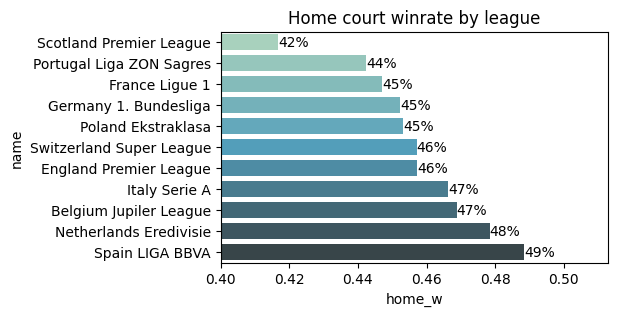

In [9]:
q = """
SELECT l.name, SUM(home_team_goal>away_team_goal)*1.0 / COUNT(*) AS home_w
FROM Match m
JOIN League l
ON m.league_id = l.id
GROUP BY m.league_id
ORDER BY home_w
"""
league_hw = pd.read_sql(q, con, index_col='name')
fig, ax = plt.subplots(figsize=(5, 3))
sns.barplot(data=league_hw, y=league_hw.index, x='home_w', palette='GnBu_d', ax=ax)
ax.bar_label(ax.containers[0], [str(round(v*100))+"%" for v in league_hw.home_w.values]);
ax.set_xlim(0.4);
ax.set_title("Home court winrate by league");

Text(0.5, 1.0, 'Home team winrate %')

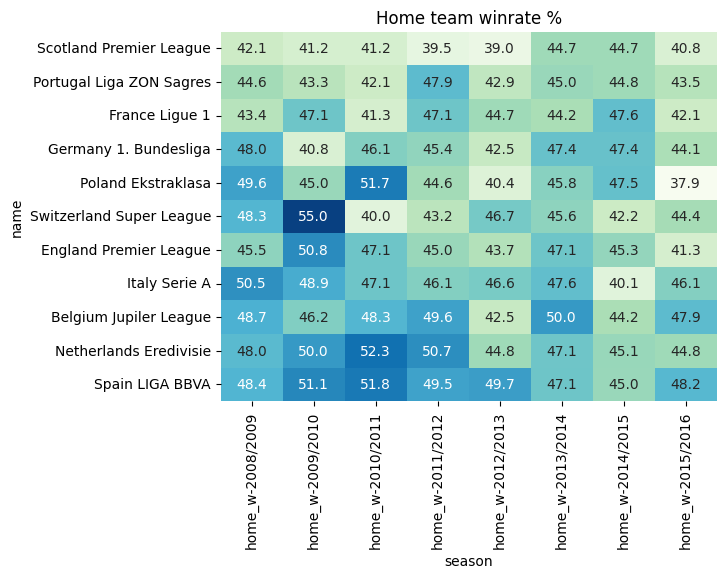

In [10]:
q = """
SELECT l.name, m.season,
SUM(home_team_goal>away_team_goal)*1.0 / COUNT(*) * 100 AS home_w
FROM Match m
JOIN League l
ON m.league_id = l.id
GROUP BY m.league_id, m.season
"""
df = pd.read_sql(q, con, index_col=['season', 'name']).unstack(0)
fig, ax = plt.subplots()
sns.heatmap(df.loc[df.mean(axis=1).sort_values().index], annot=True, cbar=False, ax=ax, cmap='GnBu', fmt=".1f")
plt.xlabel('season')
plt.title("Home team winrate %")

# Sportsbook odds dataset

* H, D, A outcome odds from 10 sportsbooks
* Total of 30 columns formatted "book"+"outcome"

In [11]:
odds_cols = ['B365H','B365D','B365A','BWH','BWD','BWA','IWH','IWD','IWA','LBH','LBD','LBA','PSH','PSD','PSA','WHH','WHD','WHA','SJH','SJD','SJA','VCH','VCD','VCA','GBH','GBD','GBA','BSH','BSD','BSA']

In [12]:
q = f"""
SELECT match_api_id,
    {", ".join(odds_cols)}, 
    CASE
        WHEN home_team_goal > away_team_goal THEN 'H'
        WHEN home_team_goal < away_team_goal THEN 'A'
        ELSE 'D'
    END outcome
FROM Match
"""
df = pd.read_sql(q, con, index_col='match_api_id')
outcome = df.loc[:, 'outcome']
odds = df.loc[:, odds_cols]
df.head()

,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,...,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA,outcome
match_api_id,,,,,,,,,,,,,,,,,,,,,
492473,1.73,3.40,5.00,1.75,3.35,4.20,1.85,3.2,3.5,1.80,...,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20,D
492474,1.95,3.20,3.60,1.80,3.30,3.95,1.90,3.2,3.5,1.90,...,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60,D
492475,2.38,3.30,2.75,2.40,3.30,2.55,2.60,3.1,2.3,2.50,...,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75,A
492476,1.44,3.75,7.50,1.40,4.00,6.80,1.40,3.9,6.0,1.44,...,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50,H
492477,5.00,3.50,1.65,5.00,3.50,1.60,4.00,3.3,1.7,4.00,...,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67,A


## Sportsbook model inspect

### Home

In [13]:
home_odds = 1 / odds.loc[:, [s for s in odds.columns if s[-1]=='H']]
home_odds = 1 - home_odds

target = {'H': 0, 'D': 1, 'A': 1}
y = outcome.apply(lambda x: target[x])
home_odds = home_odds.join(y)

seasons = {}
def get_logloss(grp: pd.DataFrame):
    return grp.drop('season', axis=1).apply(lambda x: ll(grp.loc[~x.isna(), 'outcome'], x.dropna()))

def ll(y, x):
    if x.shape[0] < 10:
        return np.NaN
    return log_loss(y, x)

grp = home_odds.join(matches.set_index('match_api_id').season).groupby('season', group_keys=True).apply(get_logloss)

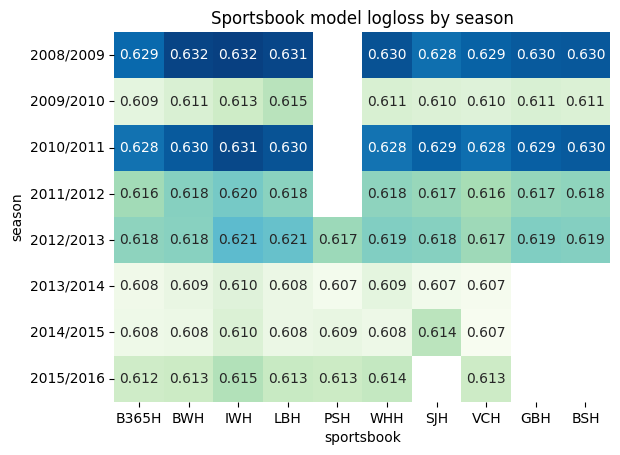

In [14]:
grp.drop('outcome', axis=1).style.background_gradient('GnBu').format(precision=3)

sns.heatmap(grp.drop('outcome', axis=1), annot=True, cbar=False, cmap='GnBu', fmt=".3f")
plt.xlabel('sportsbook')
plt.title("Sportsbook model logloss by season");

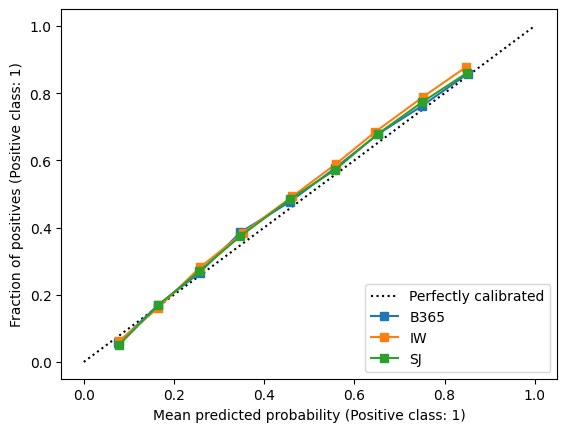

In [15]:
fig, ax = plt.subplots()
CalibrationDisplay.from_predictions(home_odds.outcome, home_odds.B365H, strategy='uniform', n_bins=10, ax=ax, name='B365')
CalibrationDisplay.from_predictions(home_odds.outcome, home_odds.IWH, strategy='uniform', n_bins=10, ax=ax, name='IW')
CalibrationDisplay.from_predictions(home_odds.outcome, home_odds.SJH, strategy='uniform', n_bins=10, ax=ax, name='SJ')

## Sportsbook spread

Bookmaker quoted odds contain margin - meaning cumulative probability is more than 1

In [16]:
spread_df = (1/odds).T.groupby(lambda x: x[:-1]).sum().T

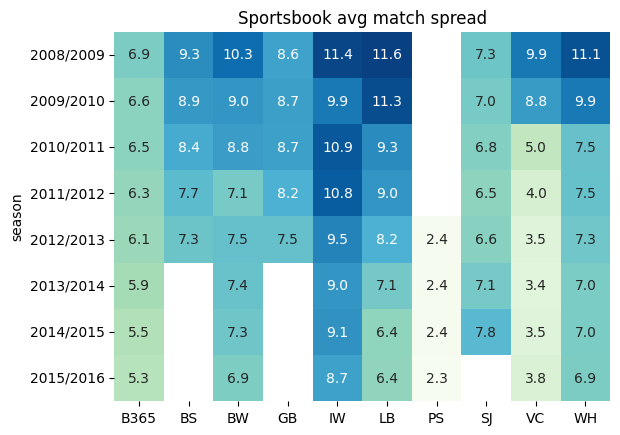

In [17]:
spread_byseason = spread_df.join(matches.set_index('match_api_id').season).groupby('season').apply(lambda x: x[x>0].mean())
spread_byseason.style.background_gradient('GnBu', axis=None)

sns.heatmap((spread_byseason-1)*100, annot=True, fmt=".1f", cbar=False, cmap='GnBu')
plt.title('Sportsbook avg match spread');

Text(0.5, 1.0, 'Sportsbook avg sum implied probability by year')

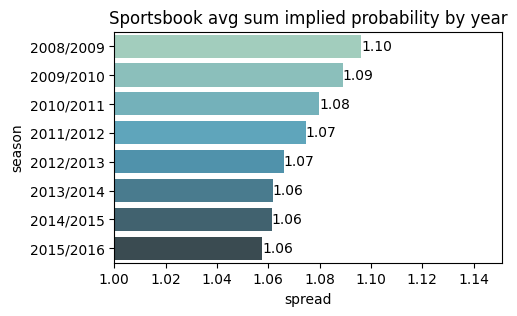

In [18]:
sdf = spread_byseason.mean(axis=1).to_frame('spread')
fig, ax = plt.subplots(figsize=(5, 3))
sns.barplot(data=sdf, x='spread', y=sdf.index, palette='GnBu_d', ax=ax)
ax.set_xlim(1)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')
ax.set_title('Sportsbook avg sum implied probability by year')

Text(0.5, 1.0, 'Sportsbook avg sum implied probability by book')

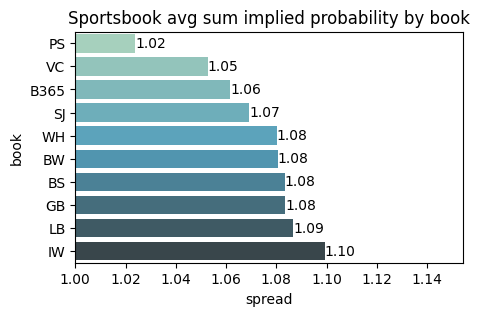

In [19]:
tdf = spread_df.apply(lambda x: x[x>0].mean(), axis=0).to_frame('spread').sort_values('spread')
fig, ax = plt.subplots(figsize=(5, 3))
sns.barplot(data=tdf, x='spread', y=tdf.index, palette='GnBu_d', ax=ax)
ax.set_ylabel('book')
ax.set_xlim(1)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')
ax.set_title('Sportsbook avg sum implied probability by book')

# Features to predict match outcome

* Information about teams become available as time goes by so it is critical not to leak information into the future

* Create window function that recalculates features for each match wrt previous games

## Features

* Least Squares League Rating:

    * lsr50_h, lsr50_a, lsr100_h, lsr100_a, lsr100_d, lsr200_h, lsr200_a, lsr200_d

* Last games: 

    * goal_diff

        * last2_gd_h, last2_gd_a, last2_gd_d, last3_gd_h, last3_gd_a, last5_gd_h, last5_gd_a, last5_gd_d, last7_gd_h, last7_gd_a, last7_gd_d, last10_gd_h, last10_gd_a, last10_gd_d, last15_gd_h, last15_gd_a, last15_gd_d      
        
    * goal_diff_between
        
        * last3_bt_gd, last5_bt_gd, last10_bt_gd

    * points
        
        * last5_points_h, last5_points_a, last5_points_d, last10_points_h, last10_points_a, last10_points_d, last20_points_h, last20_points_a, last20_points_d
        
    * scored
        
        * last2_scored_h, last2_scored_a, last2_scored_d, last3_scored_h, last3_scored_a, last3_scored_d, last5_scored_h, last5_scored_a, last5_scored_d, last7_scored_h, last7_scored_a, last7_scored_d, last10_scored_h, last10_scored_a, last10_scored_d
    
    * allowed
    
        * last2_allowed_h, last2_allowed_a, last2_allowed_d, last3_allowed_h, last3_allowed_a, last3_allowed_d, last5_allowed_h, last5_allowed_a, last5_allowed_d, last7_allowed_h, last7_allowed_a, last7_allowed_d, last10_allowed_h, last10_allowed_a, last10_allowed_d
        
    * home court advantage
    
        * last20_home_d

* Lineup attribute ratings from FIFA player ratings

    * physical_h, physical_a, physical_d, mental_h, mental_a, mental_d, skill_h, skill_a, skill_d, gk_h, gk_a, gk_d, offence_h, offence_a, offence_d, defence_h, defence_a, defence_d, overall_h, overall_a, overall_d,
    
    * offence_h - defence_a, offence_a - defence_h

* Team attribute ratings from FIFA team ratings

In [20]:
def get_matchups(x: pd.DataFrame) -> list[np.ndarray, np.ndarray]:
    """League matchup matrix (n_matches, n_teams)"""
    idx = np.sort(np.unique(x.home_team_api_id.astype(int)))
    h = x.home_team_api_id.values
    a = x.away_team_api_id.values
    # 1 home, -1 away
    m = np.zeros((h.shape[0], idx.shape[0]), dtype=np.float64)
    for j in range(h.shape[0]):
        m[j, idx==h[j]] = 1
        m[j, idx==a[j]] = -1
    return [m, idx]

@njit
def get_ls_rating_f(row: np.ndarray, x, idx, y, window, func: Callable = None) -> np.ndarray:
    """Function applied on dataframe row that gets ls rating wrt previous league games"""
    res = np.zeros(2, dtype=float)
    if row[0] < 2:
        return res
    if row[0] <= window:
        win = 0
        # slice league matchups
        x_k = x[:row[0], :]
        y_k = y[:row[0]]
    else:
        win = window
        x_k = x[row[0]-win:row[0], :]
        y_k = y[row[0]-win:row[0]]
    if func is not None:
        rating = func(x_k, y_k)
    else:
        rating = np.linalg.pinv(x_k) @ y_k
    res[0] = rating[idx==row[1]][0][0]
    res[1] = rating[idx==row[2]][0][0]
    return res 

def get_rating(g: pd.DataFrame, col: str, window: int, func: Callable):
    """Function applied on dataframe containing single league matches"""
    x, idx = get_matchups(g)
    y = g.loc[:, [col]].astype(np.float64).values
    g.loc[:, 'id'] = np.arange(0, g.shape[0], dtype=int)[:, np.newaxis]
    res = g.loc[:, ['id', 'home_team_api_id', 'away_team_api_id']]\
    .apply(lambda row: get_ls_rating_f(row.values, x, idx, y, window, func), axis=1, result_type='expand')
    return pd.DataFrame(index=g.match_api_id, data=res.values, columns=['hr', 'ar'])


## Least Squares Rating

Continuously scaled rating value, so that the strongest team will have the highest rating

https://en.wikipedia.org/wiki/Statistical_association_football_predictions#Time_Independent_Least_Squares_Rating

In [21]:
id_cols = ['league_id', 'date', 'match_api_id', 'home_team_api_id', 'away_team_api_id']
matches['gd'] = matches['home_team_goal'] - matches['away_team_goal']

### Rating from goal difference, 50 league games

In [22]:
lsr50_gd = matches.loc[:, id_cols + ['gd']]\
.groupby(['league_id'], group_keys=False)\
.apply(lambda x: get_rating(x.sort_values('date'), 'gd', 50, None))\
.rename(columns={'hr': 'lsr50_gd_h', 'ar': 'lsr50_gd_a'})
lsr50_gd.loc[:, 'lsr50_gd_d'] = lsr50_gd.lsr50_gd_h - lsr50_gd.lsr50_gd_a
lsr50_gd.head()

,lsr50_gd_h,lsr50_gd_a,lsr50_gd_d
match_api_id,,,
492474,0.0,0.0,0.0
492475,0.0,0.0,0.0
492477,0.0,0.0,0.0
492479,0.0,0.0,0.0
492480,0.0,0.0,0.0


### Rating from goal difference, 100 league games

In [23]:
lsr100_gd = matches.loc[:, id_cols + ['gd']]\
.groupby(['league_id'], group_keys=False)\
.apply(lambda x: get_rating(x.sort_values('date'), 'gd', 100, None))\
.rename(columns={'hr': 'lsr100_gd_h', 'ar': 'lsr100_gd_a'})
lsr100_gd.loc[:, 'lsr100_gd_d'] = lsr100_gd.lsr100_gd_h - lsr100_gd.lsr100_gd_a

### Rating from goal difference, 200 league games

In [24]:
lsr200_gd = matches.loc[:, id_cols + ['gd']]\
.groupby(['league_id'], group_keys=False)\
.apply(lambda x: get_rating(x.sort_values('date'), 'gd', 200, None))\
.rename(columns={'hr': 'lsr200_gd_h', 'ar': 'lsr200_gd_a'})
lsr200_gd.loc[:, 'lsr200_gd_d'] = lsr200_gd.lsr200_gd_h - lsr200_gd.lsr200_gd_a

In [25]:
lsr300_gd = matches.loc[:, id_cols + ['gd']]\
.groupby(['league_id'], group_keys=False)\
.apply(lambda x: get_rating(x.sort_values('date'), 'gd', 300, None))\
.rename(columns={'hr': 'lsr300_gd_h', 'ar': 'lsr300_gd_a'})
lsr300_gd.loc[:, 'lsr300_gd_d'] = lsr300_gd.lsr300_gd_h - lsr300_gd.lsr300_gd_a

#### Home team w % by rating advantage

In [26]:
bins = [-10, -2.5, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2.5, 10]
lsr100_gd.join(outcome).groupby(pd.cut(lsr100_gd.lsr100_gd_d, bins)).apply(lambda x: (x.outcome == 'H').sum() / x.shape[0])

lsr100_gd_d
(-10.0, -2.5]    0.194896
(-2.5, -1.5]     0.219385
(-1.5, -1.0]     0.309098
(-1.0, -0.5]     0.373617
(-0.5, 0.0]      0.437057
(0.0, 0.5]       0.472451
(0.5, 1.0]       0.543430
(1.0, 1.5]       0.642921
(1.5, 2.5]       0.726176
(2.5, 10.0]      0.822715
dtype: float64

In [27]:
lsr_features = [lsr50_gd, lsr100_gd, lsr200_gd, lsr300_gd]

## Last n games features

In [28]:
@njit
def last_games_row_f(row: np.ndarray, gdf: np.ndarray, win: list[int], func: Callable, split: str):
    prev_games = gdf[:row[0], :]
    team_idx = row[1]
    if split == 'home':
        team_fltr1 = prev_games[:, 1] == row[1]
        team_fltr2 = prev_games[:, 2] == row[1]
        team_fltr = team_fltr1 | team_fltr2
    elif split == 'away':
        team_fltr1 = prev_games[:, 1] == row[2]
        team_fltr2 = prev_games[:, 2] == row[2]
        team_fltr = team_fltr1 | team_fltr2
        team_idx = row[2]
    elif split == 'between':
        team_fltr1 = (prev_games[:, 1] == row[1]) & \
        (prev_games[:, 2] == row[2])
        team_fltr2 = (prev_games[:, 2] == row[1]) & \
        (prev_games[:, 1] == row[2])
        team_fltr = team_fltr1 | team_fltr2
    team_slc = prev_games[team_fltr, :]
    slc = team_slc[-win:, :]
    if slc.shape[0] < 1:
        return 0
    res = func(slc, team_idx)
    return res

@njit
def points_f(g: np.ndarray, idx: int) -> float:
    hgames = g[g[:, 1] == idx, -1]
    hw = (hgames > 0).sum() * 3
    hd = (hgames == 0).sum() * 1
    agames = g[g[:, 2] == idx, -1]
    aw = (agames < 0).sum() * 3
    ad = (agames == 0).sum() * 1
    return (hw + hd + aw + ad) / (hgames.shape[0] + agames.shape[0])

@njit
def scored_f(g: np.ndarray, idx: int) -> float:
    hgames = g[g[:, 1] == idx, -2]
    agames = g[g[:, 2] == idx, -1]
    return (hgames.sum() + agames.sum()) / (hgames.shape[0] + agames.shape[0])

@njit
def allowed_f(g: np.ndarray, idx: int) -> float:
    hgames = g[g[:, 1] == idx, -1]
    agames = g[g[:, 2] == idx, -2]
    return (hgames.sum() + agames.sum()) / (hgames.shape[0] + agames.shape[0])

@njit
def gdiff_f(g: np.ndarray, idx: int) -> float:
    hgames = g[g[:, 1] == idx, -1]
    agames = g[g[:, 2] == idx, -1] * (-1)
    return (hgames.sum() + agames.sum()) / (hgames.shape[0] + agames.shape[0])

@njit
def home_court_f(g: np.ndarray, idx: int) -> float:
    hgames = g[g[:, 1] == idx, -1]
    agames = g[g[:, 2] == idx, -1]
    if (hgames.shape[0] + agames.shape[0]) < 15:
        return 0.0
    return (hgames.sum() / hgames.shape[0]) - (agames.sum() / agames.shape[0])

def get_last_games_all(df: pd.DataFrame, func: Callable, window: list[int], split: str, cols: list[str]) -> pd.DataFrame:
    """Get lookup table by league and apply row function"""
    leagues = []
    for i, grp in df.loc[:, id_cols+ cols].groupby('league_id', group_keys=False):
        temp = grp.sort_values('date')
        temp.loc[:, 'id'] = np.arange(0, temp.shape[0], dtype=int)[:, np.newaxis]
        temp = temp.loc[:, ['id','home_team_api_id', 'away_team_api_id']+cols]
        last_games = [get_last_games(temp, n, func, split) for n in window]
        last_games_df = pd.concat(last_games, axis=1)
        last_games_df.columns = ["last"+str(w)+"_"+split for w in window]
        last_games_df.index = grp.sort_values('date').match_api_id
        leagues.append(last_games_df)
    return pd.concat(leagues)

def get_last_games(g: pd.DataFrame, win: int, func: Callable = None, split: str = 'home') -> pd.DataFrame:
    """Function applied on league matches table"""
    res = g.apply(lambda row: last_games_row_f(row.values, g.values, win, func, split), axis=1)
    return res

In [29]:
id_cols = ['league_id', 'date', 'match_api_id', 'home_team_api_id', 'away_team_api_id']

### Goal difference

#### Home

In [30]:
home_gd_df = get_last_games_all(matches, gdiff_f, [2, 3, 4, 5, 7, 10, 15, 20, 30, 50], 'home', ['gd'])
home_gd_df.columns = [col+"_gd" for col in home_gd_df.columns]

(-3.5, 3.5)

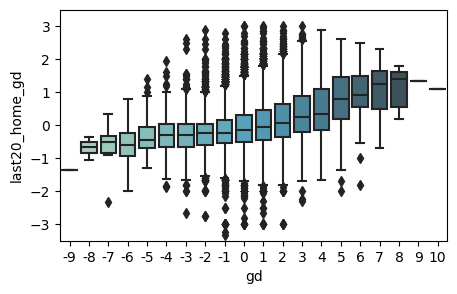

In [31]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.boxplot(data=home_gd_df.join(matches.set_index('match_api_id').gd), x='gd', y='last20_home_gd', ax=ax, palette="GnBu_d")
ax.set_ylim(-3.5, 3.5)

#### Away

In [32]:
away_gd_df = get_last_games_all(matches, gdiff_f, [2, 3, 4, 5, 7, 10, 15, 20, 30, 50], 'away', ['gd'])
away_gd_df.columns = [col+"_gd" for col in away_gd_df.columns]

(-3.5, 3.5)

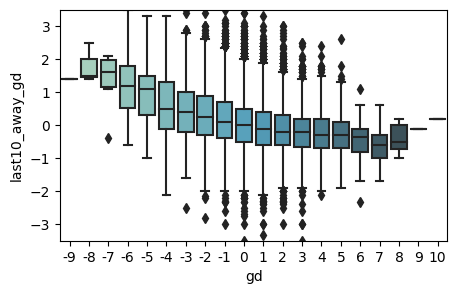

In [33]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.boxplot(data=away_gd_df.join(matches.set_index('match_api_id')), x='gd', y='last10_away_gd', ax=ax, palette="GnBu_d")
ax.set_ylim(-3.5, 3.5)

#### Advantage

In [34]:
gd_d_df = pd.DataFrame(home_gd_df.values - away_gd_df.values, columns=[col.split('_')[0]+"_gd_d" for col in home_gd_df.columns], index=home_gd_df.index)

<Axes: xlabel='gd', ylabel='last10_gd_d'>

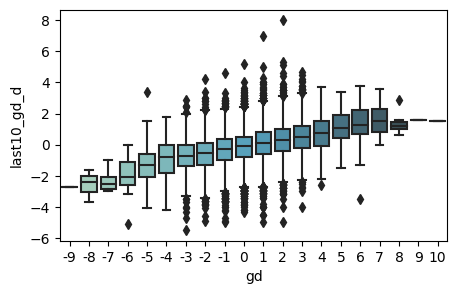

In [35]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.boxplot(data=gd_d_df.join(matches.set_index('match_api_id')), x='gd', y='last10_gd_d', ax=ax, palette="GnBu_d")
# ax.set_ylim(-4, 4)

#### Head to head

In [36]:
between_gd_df = get_last_games_all(matches, gdiff_f, [3, 4, 5], 'between', ['gd'])
between_gd_df.columns = [col+"_gd" for col in between_gd_df.columns]

<Axes: xlabel='gd', ylabel='last5_between_gd'>

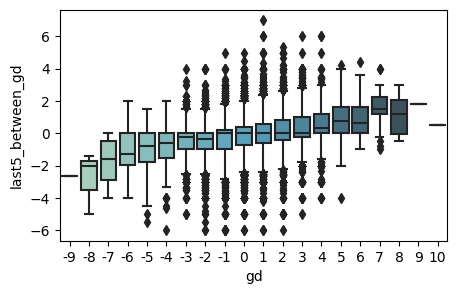

In [37]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.boxplot(data=between_gd_df.join(matches.set_index('match_api_id')), x='gd', y='last5_between_gd', ax=ax, palette="GnBu_d")

### Goals scored

#### Home

In [38]:
home_scored_df = get_last_games_all(matches, scored_f, [2, 3, 4, 5, 7, 10, 20], 'home', ['home_team_goal', 'away_team_goal'])
home_scored_df.columns = [col+"_scored" for col in home_scored_df.columns]

<Axes: xlabel='gd', ylabel='last10_home_scored'>

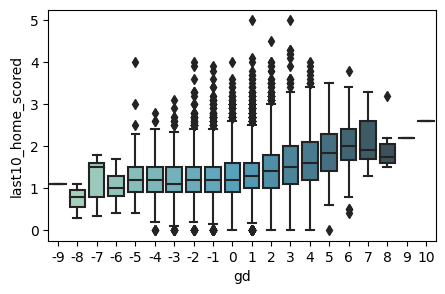

In [39]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.boxplot(data=home_scored_df.join(matches.set_index('match_api_id')), x='gd', y='last10_home_scored', ax=ax, palette="GnBu_d")

#### Away

In [40]:
away_scored_df = get_last_games_all(matches, scored_f, [2, 3, 4, 5, 7, 10, 20], 'away', ['home_team_goal', 'away_team_goal'])
away_scored_df.columns = [col+"_scored" for col in away_scored_df.columns]

<Axes: xlabel='gd', ylabel='last10_away_scored'>

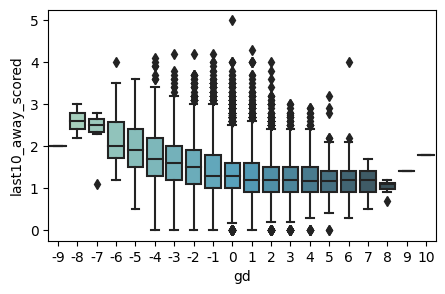

In [41]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.boxplot(data=away_scored_df.join(matches.set_index('match_api_id')), x='gd', y='last10_away_scored', ax=ax, palette='GnBu_d')

### Goals allowed

#### Home

In [42]:
home_allowed_df = get_last_games_all(matches, allowed_f, [2, 3, 4, 5, 7, 10], 'home', ['home_team_goal', 'away_team_goal'])
home_allowed_df.columns = [col+"_allowed" for col in home_allowed_df.columns]

<Axes: xlabel='gd', ylabel='last10_home_allowed'>

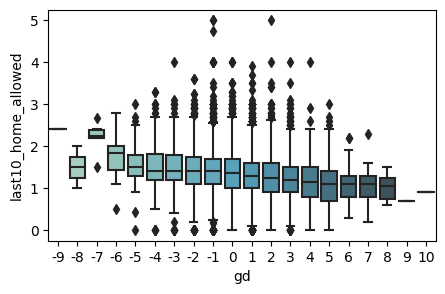

In [43]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.boxplot(data=home_allowed_df.join(matches.set_index('match_api_id')), x='gd', y='last10_home_allowed', ax=ax, palette='GnBu_d')

#### Away

In [44]:
away_allowed_df = get_last_games_all(matches, allowed_f, [2, 3, 4, 5, 7, 10], 'away', ['home_team_goal', 'away_team_goal'])
away_allowed_df.columns = [col+"_allowed" for col in away_allowed_df.columns]

<Axes: xlabel='gd', ylabel='last10_away_allowed'>

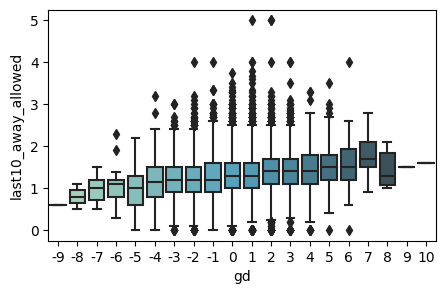

In [45]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.boxplot(data=away_allowed_df.join(matches.set_index('match_api_id')), x='gd', y='last10_away_allowed', ax=ax, palette='GnBu_d')

### Points

#### Home

In [46]:
home_points_df = get_last_games_all(matches, points_f, [2, 3, 4, 5, 7, 10, 15, 20, 30], 'home', ['gd'])
home_points_df.columns = [col+"_points" for col in home_points_df.columns]

<Axes: xlabel='gd', ylabel='last15_home_points'>

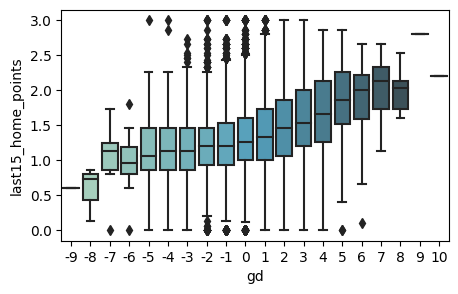

In [47]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.boxplot(data=home_points_df.join(matches.set_index('match_api_id')), x='gd', y='last15_home_points', ax=ax, palette='GnBu_d')

#### Away

In [48]:
away_points_df = get_last_games_all(matches, points_f, [2, 3, 4, 5, 7, 10, 15, 20, 30], 'away', ['gd'])
away_points_df.columns = [col+"_points" for col in away_points_df.columns]

<Axes: xlabel='gd', ylabel='last15_away_points'>

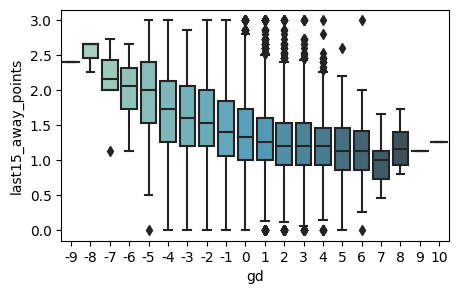

In [49]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.boxplot(data=away_points_df.join(matches.set_index('match_api_id')), x='gd', y='last15_away_points', ax=ax, palette='GnBu_d')

#### Advantage

In [50]:
points_d_df = pd.DataFrame(home_points_df.values - away_points_df.values, columns=[col.split('_')[0]+"_points_d" for col in home_points_df.columns], index=home_points_df.index)

<Axes: xlabel='gd', ylabel='last15_points_d'>

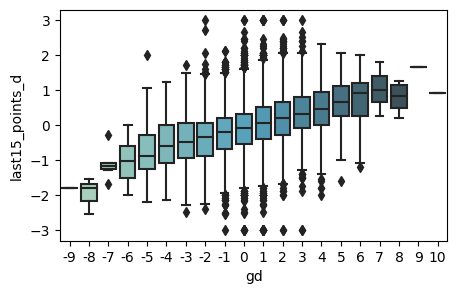

In [51]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.boxplot(data=points_d_df.join(matches.set_index('match_api_id')), x='gd', y='last15_points_d', ax=ax, palette='GnBu_d')

### Home court advantage

In [52]:
home_court_df = get_last_games_all(matches, home_court_f, [20], 'home', ['gd'])

<Axes: xlabel='gd', ylabel='last20_home'>

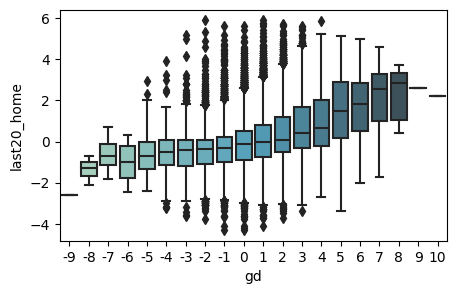

In [53]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.boxplot(data=home_court_df.join(matches.set_index('match_api_id')), x='gd', y='last20_home', ax=ax, palette='GnBu_d')

In [54]:
last_games_features = [home_gd_df, away_gd_df, gd_d_df, between_gd_df, home_scored_df, away_scored_df, home_allowed_df, away_allowed_df, home_points_df, away_points_df, points_d_df, home_court_df]

In [55]:
reduced_last_games_features = [gd_d_df.loc[:, ['last4_gd_d', 'last10_gd_d', 'last30_gd_d']], between_gd_df.loc[:, ['last4_between_gd']], points_d_df.loc[:, ['last4_points_d', 'last10_points_d', 'last30_points_d']], home_court_df]

## Lineup rating

* Features from Player_Attributes table

* For each player in a match lookup latest FIFA rating to get avg class rating per team

* Write generated ratings to new table `Lineup_Rating`

In [56]:
# rating grouping
physical = ['acceleration', 'agility', 'balance', 'jumping', 'reactions', 'sprint_speed', 'stamina', 'strength']
mental = ['aggression', 'interceptions', 'marking', 'vision']
skill = ['ball_control', 'crossing', 'curve', 'dribbling', 'finishing', 'free_kick_accuracy', 'heading_accuracy', 'long_passing', 'long_shots', 'penalties', 'positioning', 'short_passing', 'shot_power', 'sliding_tackle', 'standing_tackle', 'volleys']
gk = ['gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']
offence = ['aggression', 'vision', 'ball_control', 'crossing', 'curve', 'dribbling', 'finishing', 'free_kick_accuracy', 'heading_accuracy', 'long_passing', 'long_shots', 'penalties', 'positioning', 'short_passing', 'shot_power', 'volleys']
defence = ['interceptions', 'marking', 'sliding_tackle', 'standing_tackle']
overall = ['overall_rating']
rating_classes = physical + mental + skill + gk + offence + defence + overall

In [57]:
# lineup columns in Match table
homep = ['home_player_1','home_player_2','home_player_3','home_player_4','home_player_5','home_player_6','home_player_7','home_player_8','home_player_9','home_player_10','home_player_11']
awayp = ['away_player_1','away_player_2','away_player_3','away_player_4','away_player_5','away_player_6','away_player_7','away_player_8','away_player_9','away_player_10','away_player_11']

In [58]:
def get_player_attrs(row: pd.Series, ratings_df: pd.DataFrame, classes: list[str]):
    """Function applied on Match table row.
    Lookup latest player ratings for home and away teams
    [(n_players, n_classes), (n_players, n_classes)]
    """
    players = row.iloc[-22:].astype(np.int64)
    players.name = 'player_api_id'
    hp = players.iloc[:-11]    # home
    ap = players.iloc[-11:]    # away
    hp = hp.loc[hp!=0]
    ap = ap.loc[ap!=0]
    # latest issued rating for each player wrt match date
    slc = ratings_df.loc[players[players!=0], :]
    slc = slc.loc[slc.date < row['date']]        
    slc = slc.groupby('player_api_id').last()
    # lineup average rating
    home_ratings_arr = slc.loc[hp.values, classes].mean().values
    away_ratings_arr = slc.loc[ap.values, classes].mean().values
    if (ap==0).sum() > 6:
        away_ratings_arr = np.zeros(len(classes))
    if (hp==0).sum() > 6:
        home_ratings_arr = np.zeros(len(classes))
    return [home_ratings_arr, away_ratings_arr]
    
def create_lineup_ratings():
    """Generate home and away lineup ratings for each match"""
    q = f"""
    SELECT datetime(pa.date) AS date, pa.player_api_id, {', '.join(set(rating_classes))}
    FROM Player_Attributes AS pa
    """
    player_attrs_df = pd.read_sql(q, con, index_col='player_api_id')
    slc = matches[['match_api_id', 'date', 'home_team_api_id', 'away_team_api_id']+homep+awayp]
    slc.loc[:, homep+awayp] = slc.loc[:, homep+awayp].fillna(0).astype(np.int64)
    h = []
    a = []
    distinct_classes = list(set(rating_classes))
    for i, row in slc.iterrows():
        res = get_player_attrs(row, player_attrs_df, distinct_classes)
        h.append(res[0])
        a.append(res[1])

    home_player_ratings = pd.DataFrame(np.vstack(h), columns=[c+'_h' for c in distinct_classes], index=slc.match_api_id).apply(lambda x: x.fillna(x.mean()), axis=0)
    away_player_ratings = pd.DataFrame(np.vstack(a), columns=[c+'_a' for c in distinct_classes], index=slc.match_api_id).apply(lambda x: x.fillna(x.mean()), axis=0)
    
    def add_h(x: list[str]):
        return [s+"_h" for s in x]

    home_player_ratings.loc[:, 'physical_h'] = home_player_ratings.loc[:, add_h(physical)].mean(axis=1)
    home_player_ratings.loc[:, 'mental_h'] = home_player_ratings.loc[:, add_h(mental)].mean(axis=1)
    home_player_ratings.loc[:, 'skill_h'] = home_player_ratings.loc[:, add_h(skill)].mean(axis=1)
    home_player_ratings.loc[:, 'gk_h'] = home_player_ratings.loc[:, add_h(gk)].mean(axis=1)
    home_player_ratings.loc[:, 'offence_h'] = home_player_ratings.loc[:, add_h(offence)].mean(axis=1)
    home_player_ratings.loc[:, 'defence_h'] = home_player_ratings.loc[:, add_h(defence)].mean(axis=1)
    
    def add_a(x: list[str]):
        return [s+"_a" for s in x]

    away_player_ratings.loc[:, 'physical_a'] = away_player_ratings.loc[:, add_a(physical)].mean(axis=1)
    away_player_ratings.loc[:, 'mental_a'] = away_player_ratings.loc[:, add_a(mental)].mean(axis=1)
    away_player_ratings.loc[:, 'skill_a'] = away_player_ratings.loc[:, add_a(skill)].mean(axis=1)
    away_player_ratings.loc[:, 'gk_a'] = away_player_ratings.loc[:, add_a(gk)].mean(axis=1)
    away_player_ratings.loc[:, 'offence_a'] = away_player_ratings.loc[:, add_a(offence)].mean(axis=1)
    away_player_ratings.loc[:, 'defence_a'] = away_player_ratings.loc[:, add_a(defence)].mean(axis=1)
    
    all_attrs = home_player_ratings.join(away_player_ratings)
    all_attrs.loc[:, 'physical_d'] = all_attrs.physical_h - all_attrs.physical_a
    all_attrs.loc[:, 'skill_d'] = all_attrs.skill_h - all_attrs.skill_a
    all_attrs.loc[:, 'mental_d'] = all_attrs.mental_h - all_attrs.mental_a
    all_attrs.loc[:, 'offence_d'] = all_attrs.offence_h - all_attrs.offence_a
    all_attrs.loc[:, 'defence_d'] = all_attrs.defence_h - all_attrs.defence_a
    all_attrs.loc[:, 'offvdef_h'] = all_attrs.offence_h - (all_attrs.loc[:, ['defence_a', 'gk_a']].mean(axis=1))
    all_attrs.loc[:, 'offvdef_a'] = all_attrs.offence_a - (all_attrs.loc[:, ['defence_h', 'gk_h']].mean(axis=1))
    all_attrs.loc[:, 'offvdef_d'] = all_attrs.offvdef_h - all_attrs.offvdef_a
    all_attrs.loc[:, 'overall_rating_d'] = all_attrs.overall_rating_h - all_attrs.overall_rating_a
    all_attrs.to_sql(name="Lineup_Rating", con=con)
    return all_attrs

In [59]:
q = """
SELECT name FROM sqlite_master WHERE type='table' AND name='Lineup_Rating'
"""
if pd.read_sql(q, con).shape[0]:
    q= """
    SELECT * FROM Lineup_Rating
    """
    all_attrs=pd.read_sql(q, con, index_col='match_api_id')
else:
    all_attrs = create_lineup_ratings()

In [60]:
reduced_lineup_ratings = ['physical_d', 'skill_d', 'mental_d', 'offence_d', 'defence_d', 'offvdef_h', 'offvdef_a', 'offvdef_d', 'overall_rating_d']

## Team attributes

In [61]:
q = """
SELECT datetime(date) date, team_api_id, buildUpPlaySpeed, buildUpPlayDribbling, buildUpPlayPassing, chanceCreationPassing, chanceCreationCrossing, chanceCreationShooting, defencePressure, defenceAggression, defenceTeamWidth
FROM Team_Attributes
ORDER BY datetime(date)
"""
t_attrs = pd.read_sql(q, con, index_col='team_api_id')
t_attrs.date = pd.to_datetime(t_attrs.date)

In [62]:
attrs = ['buildUpPlaySpeed', 'buildUpPlayDribbling', 'buildUpPlayPassing', 'chanceCreationPassing', 'chanceCreationCrossing', 'chanceCreationShooting', 'defencePressure', 'defenceAggression', 'defenceTeamWidth']

In [63]:
teamh = np.zeros((matches.shape[0], len(attrs)), dtype=float)
teama = np.zeros((matches.shape[0], len(attrs)), dtype=float)

for i, row in matches.iterrows():
    before_attrs = t_attrs.loc[t_attrs.date < row.date, attrs]
    try:
        h_attrs = before_attrs.loc[row.home_team_api_id, :]
        h_attrs = h_attrs.groupby('team_api_id').last()
        teamh[i, :] = h_attrs.values
    except KeyError:
        teamh[i, :] = np.NaN
    try:
        a_attrs = before_attrs.loc[row.away_team_api_id, :]
        if a_attrs.shape[0] < 1:
            raise KeyError
        a_attrs = a_attrs.groupby('team_api_id').last()
        teama[i, :] = a_attrs.values
    except KeyError:
        teama[i, :] = np.NaN

In [64]:
teamh_df = pd.DataFrame(data=teamh, index=matches.match_api_id, columns=[a+'_h' for a in attrs])
teama_df = pd.DataFrame(data=teama, index=matches.match_api_id, columns=[a+'_a' for a in attrs])
team_df = teamh_df.join(teama_df)
team_df = team_df.apply(lambda x: x.fillna(x.mean()))

In [65]:
team_df.head()

,buildUpPlaySpeed_h,buildUpPlayDribbling_h,buildUpPlayPassing_h,chanceCreationPassing_h,chanceCreationCrossing_h,chanceCreationShooting_h,defencePressure_h,defenceAggression_h,defenceTeamWidth_h,buildUpPlaySpeed_a,buildUpPlayDribbling_a,buildUpPlayPassing_a,chanceCreationPassing_a,chanceCreationCrossing_a,chanceCreationShooting_a,defencePressure_a,defenceAggression_a,defenceTeamWidth_a
match_api_id,,,,,,,,,,,,,,,,,,
492473,52.991007,49.13256,48.198028,52.694493,54.18457,52.891466,45.893947,48.814624,52.342719,52.949932,49.103976,48.169376,52.683335,54.162737,52.90067,45.887889,48.787629,52.370952
492474,52.991007,49.13256,48.198028,52.694493,54.18457,52.891466,45.893947,48.814624,52.342719,52.949932,49.103976,48.169376,52.683335,54.162737,52.90067,45.887889,48.787629,52.370952
492475,52.991007,49.13256,48.198028,52.694493,54.18457,52.891466,45.893947,48.814624,52.342719,52.949932,49.103976,48.169376,52.683335,54.162737,52.90067,45.887889,48.787629,52.370952
492476,52.991007,49.13256,48.198028,52.694493,54.18457,52.891466,45.893947,48.814624,52.342719,52.949932,49.103976,48.169376,52.683335,54.162737,52.90067,45.887889,48.787629,52.370952
492477,52.991007,49.13256,48.198028,52.694493,54.18457,52.891466,45.893947,48.814624,52.342719,52.949932,49.103976,48.169376,52.683335,54.162737,52.90067,45.887889,48.787629,52.370952


# Model

* XGBoost + Logistic Regression

* Train seasons: ['2009/2010', '2010/2011', '2011/2012', '2012/2013', '2013/2014', '2014/2015']

* Test seasons: ['2015/2016']

## XGB model

In [66]:
def norm(x):
    return (x - x.min()) / (x.max() - x.min())

class XGBModel:
    def __init__(self, cfg: dict):
        self.config = cfg
        self.best_params = None
        self.bst = None
        self.dtrain = None
        self.dtest = None
        
    def train_test_split(self, features, labels, train_seasons, test_seasons):
        X = features.loc[:, features.columns!='outcome'].join(matches.set_index('match_api_id')[['season', 'date']])
        X_train = X.loc[X.season.isin(train_seasons), :]
        y_train = labels.loc[X.season.isin(train_seasons)]
        ws = np.ones(X_train.shape[0], dtype=float)
        X_test = X.loc[X.season.isin(test_seasons), :]
        y_test = labels.loc[X.season.isin(test_seasons)]
        X_train = X_train.drop(['season', 'date'], axis=1)
        X_test = X_test.drop(['season', 'date'], axis=1)
        self.X_train, self.y_train = X_train, y_train
        self.X_test, self.y_test = X_test, y_test
        dtrain = xgb.DMatrix(data=X_train, label=y_train, feature_names=X_train.columns, weight=ws)
        dtest = xgb.DMatrix(data=X_test, label=y_test, feature_names=X_train.columns)
        self.dtrain, self.dtest = dtrain, dtest
        return dtrain, dtest

    def _train_model(self, dtrain, dtest, cfg = {}, verbose=0, model=None):
        config = self.config.copy()
        config.update(cfg)
        if model is not None:
            config ={
                'updater':'refresh',
                'process_type': 'update',
                'refresh_leaf': True,
                'eta': 0.01,
                'objective': 'binary:logistic',
                'eval_metric': 'logloss',
            }.update(cfg)
        bst = xgb.train(config, dtrain, num_boost_round=5000, xgb_model=model,
                        evals=[(dtrain, 'train'), (dtest, 'eval')], 
                        early_stopping_rounds=50, verbose_eval=verbose) 
        return bst
    
    def search_params(self, features, labels, train_seasons, test_seasons, n_trials=50, cfg={}):
        dtrain, dtest = self.train_test_split(features, labels, train_seasons, test_seasons)
        def objective(trial):
            config = {
                'max_depth': trial.suggest_int("max_depth", 2, 10),
                'reg_lambda': trial.suggest_int("lambda", 0, 200, step=5),
                'alpha': trial.suggest_int('alpha', 0, 100, step=5),
                'gamma': trial.suggest_int("gamma", 0, 50, step=2),
                'colsample_bytree': trial.suggest_float("colsample_bytree", 0.1, 0.7, step=0.1),
                'min_child_weight': trial.suggest_int('min_child_weight', 0, 30)
            }
            config.update(cfg)
            bst = self._train_model(dtrain, dtest, config)
            y_pred_proba_xgb = bst.predict(dtest)
            return log_loss(dtest.get_label(), y_pred_proba_xgb)
        study = optuna.create_study(direction="minimize")
        study.optimize(objective, n_trials=n_trials, timeout=600)
        trial = study.best_trial
        self.best_params = trial.params
        return trial.params

    def train_model(self, features, labels, train_s, test_s, cfg={}, verbose=0):
        dtrain, dtest = self.train_test_split(features, labels, train_s, test_s)
        bst = self._train_model(dtrain, dtest, cfg, verbose)
        self.bst = bst
        return bst
                
    def print_report(self):
        if self.bst is None: return None
        y_pred_proba_test = self.bst.predict(self.dtest)
        ll = log_loss(self.dtest.get_label(), y_pred_proba_test)
        auc = roc_auc_score(self.dtest.get_label(), y_pred_proba_test)
        print('Log loss: ', round(ll, 4))
        print('AUC: ', round(auc, 4))
        report = classification_report((y_pred_proba_test>=0.5).astype(int), self.dtest.get_label())
        print(report)
        
    def plot_calibration(self):
        if self.bst is None: return None
        fig, ax = plt.subplots()
        CalibrationDisplay.from_predictions(self.dtrain.get_label(), self.bst.predict(self.dtrain), strategy='uniform', n_bins=8, ax=ax, name='Train')
        CalibrationDisplay.from_predictions(self.dtest.get_label(), self.bst.predict(self.dtest), strategy='uniform', n_bins=8, ax=ax, name='Test')

    def plot_shap(self):
        if self.bst is None: return None
        shap_values_xgb = self.bst.predict(self.dtrain, pred_contribs=True)
        fig, ax = plt.subplots()
        shap.summary_plot(
            shap_values_xgb[:, :-1], self.dtrain.get_data().toarray(), 
            feature_names=self.dtrain.feature_names, plot_type="bar",
            plot_size=(5, 5))

## Logistic regression

In [67]:
class LOGRModel:
    def __init__(self):
        self.pipeline = None
        self.X_train = None
        self.X_test = None
        self.y_test = None
        self.y_train = None
    
    def train_test_split(self, features, labels, train_seasons, test_seasons):
        X = features.loc[:, features.columns!='outcome'].join(matches.set_index('match_api_id').season)
        X_train = X.loc[X.season.isin(train_seasons), :]
        y_train = labels.loc[X.season.isin(train_seasons)]
        X_test = X.loc[X.season.isin(test_seasons), :]
        y_test = labels.loc[X.season.isin(test_seasons)]
        X_train = X_train.drop('season', axis=1)
        X_test = X_test.drop('season', axis=1)
        return X_train, X_test, y_train, y_test
    
    def train_model(self, features, labels, train, test, cfg={}):
        self.X_train, self.X_test, self.y_train, self.y_test = self.train_test_split(features, labels, train, test)        
        self.pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', LogisticRegression(
                **cfg
            ))])
        self.pipeline.fit(self.X_train, self.y_train)
        return self.pipeline
    
    def search_params(self, features, labels, train_seasons, test_seasons, n_trials=50, cfg={}):
        def objective(trial):
            config = {
                'C': trial.suggest_float('C', 0.05, 1, 0.05),
                'max_iter': 5000
            }
            config.update(cfg)
            pipe = self.train_model(features, labels, train_seasons, test_seasons, config)
            y_pred_proba_lr = pipe.predict_proba(self.X_test)[:, 1]
            return log_loss(self.y_test, y_pred_proba_lr)
        study = optuna.create_study(direction="minimize")
        study.optimize(objective, n_trials=n_trials, timeout=600)
        trial = study.best_trial
        self.best_params = trial.params
        return trial.params
    
        
    def print_report(self):
        predictions = self.pipeline.predict(self.X_test)
        y_pred_proba_lr = self.pipeline.predict_proba(self.X_test)
        print('logloss', log_loss(self.y_test, y_pred_proba_lr[:, -1]))
        print('roc auc', roc_auc_score(self.y_test, y_pred_proba_lr[:, -1]))
        print(classification_report(predictions, self.y_test))
        
    def plot_calibration(self):
        fig, ax = plt.subplots()
        CalibrationDisplay.from_predictions(self.y_train, self.pipeline.predict_proba(self.X_train)[:, -1], strategy='uniform', n_bins=8, ax=ax, name='Train')
        CalibrationDisplay.from_predictions(self.y_test, self.pipeline.predict_proba(self.X_test)[:, -1], strategy='uniform', n_bins=8, ax=ax, name='Test')

## Features

In [68]:
features = pd.concat(last_games_features+lsr_features, axis=1).join(all_attrs).join(team_df)
features.head()

,last2_home_gd,last3_home_gd,last4_home_gd,last5_home_gd,last7_home_gd,last10_home_gd,last15_home_gd,last20_home_gd,last30_home_gd,last50_home_gd,...,defenceTeamWidth_h,buildUpPlaySpeed_a,buildUpPlayDribbling_a,buildUpPlayPassing_a,chanceCreationPassing_a,chanceCreationCrossing_a,chanceCreationShooting_a,defencePressure_a,defenceAggression_a,defenceTeamWidth_a
match_api_id,,,,,,,,,,,,,,,,,,,,,
492474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,52.342719,52.949932,49.103976,48.169376,52.683335,54.162737,52.90067,45.887889,48.787629,52.370952
492475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,52.342719,52.949932,49.103976,48.169376,52.683335,54.162737,52.90067,45.887889,48.787629,52.370952
492477,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,52.342719,52.949932,49.103976,48.169376,52.683335,54.162737,52.90067,45.887889,48.787629,52.370952
492479,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,52.342719,52.949932,49.103976,48.169376,52.683335,54.162737,52.90067,45.887889,48.787629,52.370952
492480,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,52.342719,52.949932,49.103976,48.169376,52.683335,54.162737,52.90067,45.887889,48.787629,52.370952


### Extra features

In [69]:
stage_feature = matches.set_index("match_api_id").groupby('league_id', group_keys=False).stage.apply(lambda x: norm(x))
stage_feature.head()

match_api_id
492473    0.0
492474    0.0
492475    0.0
492476    0.0
492477    0.0
Name: stage, dtype: float64

In [70]:
matches.loc[:, 'date'] = pd.to_datetime(matches.date)
time_feature = (matches.date.max() - matches.date).dt.days
time_feature.name = 'yr'
time_feature.index = matches.match_api_id

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`


In [71]:
features = features.join(stage_feature).join(time_feature)

In [72]:
reduced_features = pd.concat(reduced_last_games_features+lsr_features, axis=1).join(team_df).join(all_attrs.loc[:, reduced_lineup_ratings]).join(stage_feature)

## Labels

In [73]:
labels = features.join(outcome).outcome
labels.head()

match_api_id
492474    D
492475    A
492477    A
492479    D
492480    A
Name: outcome, dtype: object

## Home

### XGB params

In [74]:
optuna.logging.set_verbosity(optuna.logging.INFO)

In [75]:
config = {
    'eta': 0.01,
    'objective': 'binary:logistic',
    'tree_method': 'gpu_hist',
    'eval_metric': 'logloss',
    }
xgb_model_home = XGBModel(config)

In [76]:
train_seasons = ['2009/2010', '2010/2011', '2011/2012', '2012/2013', '2013/2014', '2014/2015']
test_seasons = ['2015/2016']

In [77]:
target ={'H': 0, 'D': 1, 'A': 1}
params = xgb_model_home.search_params(features, labels.apply(lambda x: target[x]), train_seasons, test_seasons, 100)

[I 2024-04-19 17:03:31,079] A new study created in memory with name: no-name-a273f3aa-2a85-4ca2-a2ba-73b22c6a7a7f
[I 2024-04-19 17:03:34,444] Trial 0 finished with value: 0.63754530818752 and parameters: {'max_depth': 5, 'lambda': 40, 'alpha': 95, 'gamma': 24, 'colsample_bytree': 0.6, 'min_child_weight': 28}. Best is trial 0 with value: 0.63754530818752.
[I 2024-04-19 17:03:37,001] Trial 1 finished with value: 0.6384125296807802 and parameters: {'max_depth': 2, 'lambda': 90, 'alpha': 85, 'gamma': 38, 'colsample_bytree': 0.2, 'min_child_weight': 24}. Best is trial 0 with value: 0.63754530818752.
[I 2024-04-19 17:03:46,889] Trial 2 finished with value: 0.6315681464773497 and parameters: {'max_depth': 7, 'lambda': 150, 'alpha': 70, 'gamma': 0, 'colsample_bytree': 0.5, 'min_child_weight': 30}. Best is trial 2 with value: 0.6315681464773497.
[I 2024-04-19 17:03:49,240] Trial 3 finished with value: 0.6378991129105731 and parameters: {'max_depth': 9, 'lambda': 85, 'alpha': 75, 'gamma': 36, 'c

In [78]:
cfg = {
    'max_depth': 6, 
    'lambda': 30, 
    'alpha': 0, 
    'gamma': 5, 
    'colsample_bytree': 0.1, 
    'min_child_weight': 20
} 

target ={'H': 0, 'D': 1, 'A': 1}

xgb_model_home.train_model(features, labels.apply(lambda x: target[x]), train_seasons, test_seasons, cfg, 0)

In [79]:
xgb_model_home.print_report()

Log loss:  0.6295
AUC:  0.6773
              precision    recall  f1-score   support

           0       0.46      0.62      0.53      1087
           1       0.78      0.65      0.71      2239

    accuracy                           0.64      3326
   macro avg       0.62      0.63      0.62      3326
weighted avg       0.67      0.64      0.65      3326



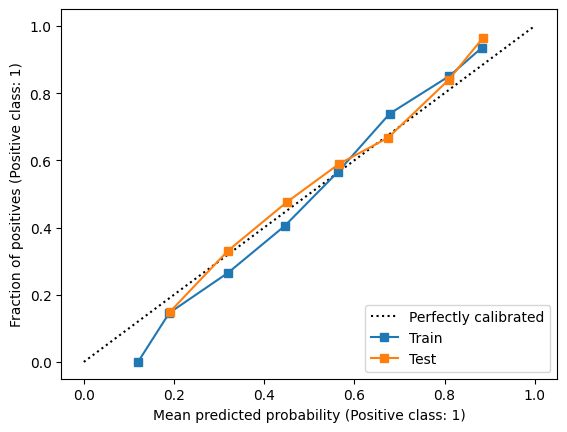

In [80]:
xgb_model_home.plot_calibration()

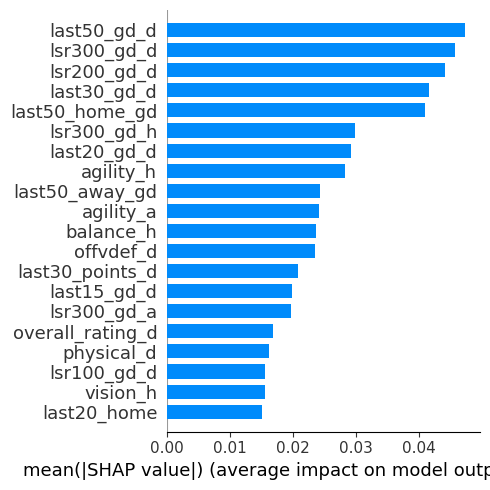

In [81]:
xgb_model_home.plot_shap()

### Logreg params

In [82]:
target ={'H': 0, 'D': 1, 'A': 1}

lr_model_home = LOGRModel()

In [83]:
train_seasons = ['2009/2010', '2010/2011', '2011/2012', '2012/2013', '2013/2014', '2014/2015']
test_season = ['2015/2016']

In [84]:
cfg = {
    'C': 1.0,
    'max_iter': 5000
}
lr_model_home.train_model(features, labels.apply(lambda x: target[x]), train_seasons, test_seasons, cfg)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', LogisticRegression(max_iter=5000))])

In [85]:
lr_model_home.print_report()

logloss 0.6286272000565473
roc auc 0.680719527833263
              precision    recall  f1-score   support

           0       0.47      0.62      0.53      1112
           1       0.77      0.65      0.71      2214

    accuracy                           0.64      3326
   macro avg       0.62      0.63      0.62      3326
weighted avg       0.67      0.64      0.65      3326



# Model compare

* Compare logloss and probability distributions

* Take bets where predicted probability higher than best odds available

* Applying Kelly criterion to bet sizing https://en.wikipedia.org/wiki/Kelly_criterion

In [86]:
def get_logloss(grp: pd.DataFrame):
    return grp.apply(lambda x: ll(grp.loc[~x.isna(), 'outcome'], x.dropna()))

def ll(y, x):
    if x.shape[0] < 10:
        return np.NaN
    return log_loss(y, x)

def compare_p_bins(predicted: pd.Series, side: str):
    sample = get_sportsbooks(predicted, side)
    bins = np.arange(0, 1.05, 0.1)
    res = []
    for col in sample.columns:
        r = sample.groupby(pd.cut(sample[col], bins)).outcome.mean()
        r.name = col
        res.append(r)
    return pd.concat(res, axis=1).drop(['GBH', 'BSH', 'SJH'], axis=1)

def compare_logloss(predicted: pd.Series, side: str):
    sample_odds = get_sportsbooks(predicted, side)
    ll = get_logloss(sample_odds).round(4)
    return ll

def get_sportsbooks(predicted: pd.Series, side):
    t = {'H': 0, 'D': 0, 'A': 0}
    t[side] = 1
    selector = [s for s in odds.columns if s[-1]==side]
    return predicted.to_frame().join( 1 / odds[selector]).join(outcome.apply(lambda x: t[x]))
    
def get_deals(predicted, side, thresh: float = 0.03):    
    sample = get_sportsbooks(predicted, side)
    # get max price difference 
    price_diff = sample.loc[:, [s for s in odds.columns if s[-1]==side]].subtract(sample[predicted.name], axis=0)
    price_diff = price_diff.min(axis=1).dropna()
    price_diff.name = 'book_price_diff'
    price_diff = sample.loc[:, [predicted.name]].join(price_diff, how='right')
    # filter 'deals'
    price_lower = price_diff[price_diff.book_price_diff < -thresh]
    price_paid = price_lower[predicted.name] + price_lower.book_price_diff
    # kc sizing 
    kc_predicted = price_lower[predicted.name]
    kc = kc_predicted - ((1-kc_predicted) / (1/price_paid - 1) )
    kc_pos = kc[kc>0]
    stake = 1 * kc_pos
    target = {'H': 0, 'D': 0, 'A': 0}
    target[side] = 1
    price_lower = price_lower[kc>0].join(outcome.apply(lambda x: target[x]))
    reward_c = stake / price_paid
    reward = reward_c * price_lower.outcome
    rpnl = reward - stake
    df = pd.concat([price_paid, kc, stake, reward_c, reward, rpnl, price_lower.outcome], axis=1)
    df.columns = ['price', 'kc', 'stake', 'reward_c', 'reward', 'rpnl', 'outcome']
    return df

### Avg model better than standalone

In [87]:
y_xgb = xgb_model_home.bst.predict(xgb_model_home.dtest)
y_lr = lr_model_home.pipeline.predict_proba(lr_model_home.X_test)[:, 0]
pred_avg = ((1-y_xgb) + y_lr) / 2

In [88]:
slc = lr_model_home.y_test.to_frame()
slc.loc[:, 'pred_avg'] = pred_avg
slc.loc[:, 'pred_xgb'] = 1-y_xgb
slc.loc[:, 'pred_lr'] = y_lr
slc.head()

,outcome,pred_avg,pred_xgb,pred_lr
match_api_id,,,,
1979832,0,0.148613,0.173089,0.124137
1979833,0,0.450059,0.444054,0.456065
1979834,0,0.579527,0.571742,0.587313
1979835,0,0.415853,0.387582,0.444124
1979836,0,0.373604,0.390155,0.357053


In [89]:
compare_logloss(slc.pred_avg, 'H')

pred_avg    0.6275
B365H       0.6124
BWH         0.6129
IWH         0.6152
LBH         0.6132
PSH         0.6129
WHH         0.6136
SJH            NaN
VCH         0.6127
GBH            NaN
BSH            NaN
outcome     0.0000
dtype: float64

In [90]:
# set min price diff to take bet
deals_h = get_deals(slc.pred_avg, 'H', 0.07)
deals_h = deals_h.join(matches.set_index('match_api_id').date).sort_values('date')

In [91]:
# % bets taken
deals_h.shape[0] / slc.shape[0]

0.13680096211665665

In [92]:
# roe %
deals_h.rpnl.sum() / deals_h.stake.sum()

0.11458011375602094

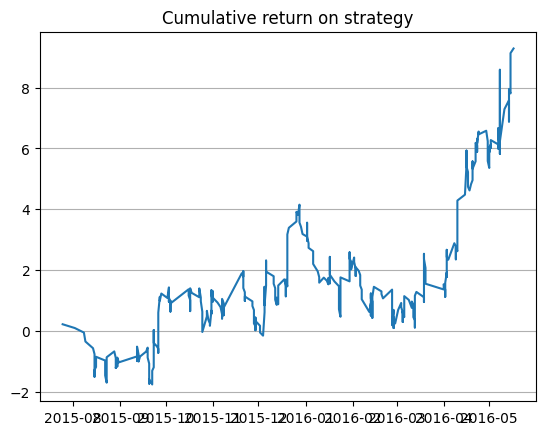

In [93]:
# big variance in returns
plt.plot(deals_h.date, deals_h.rpnl.cumsum())
plt.title("Cumulative return on strategy");
plt.grid(axis='y')

In [94]:
test_sample_odds = get_sportsbooks(slc.pred_avg, 'H')

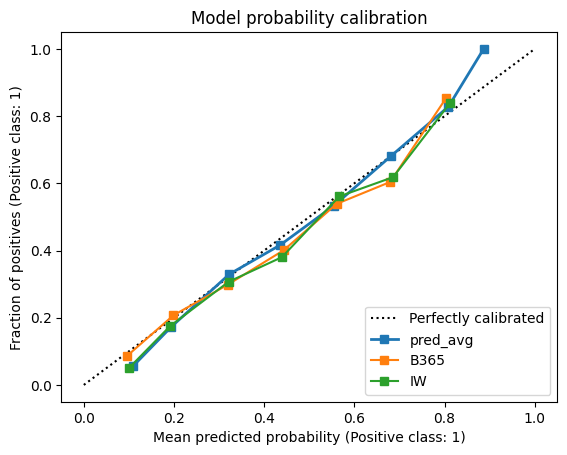

In [95]:
fig, ax = plt.subplots()
CalibrationDisplay.from_predictions(test_sample_odds.outcome, test_sample_odds.pred_avg, strategy='uniform', n_bins=8, ax=ax, name='pred_avg', lw=2)
CalibrationDisplay.from_predictions(test_sample_odds.outcome, test_sample_odds.B365H, strategy='uniform', n_bins=8, ax=ax, name='B365')
CalibrationDisplay.from_predictions(test_sample_odds.outcome, test_sample_odds.IWH, strategy='uniform', n_bins=8, ax=ax, name='IW')
plt.title("Model probability calibration");

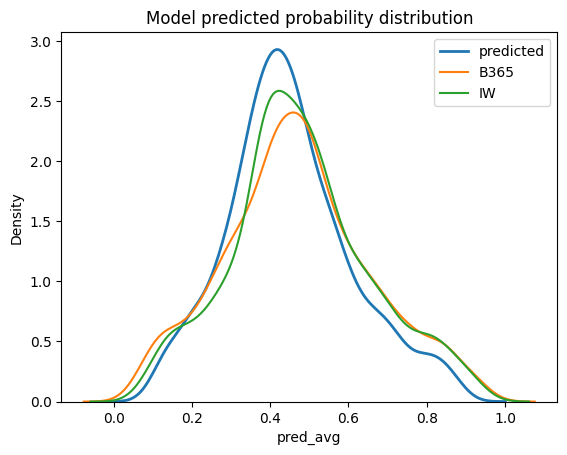

In [96]:
sns.kdeplot(test_sample_odds.pred_avg, label='predicted', lw=2)
sns.kdeplot(test_sample_odds.B365H, label='B365')
sns.kdeplot(test_sample_odds.IWH, label='IW')
plt.legend()
plt.title("Model predicted probability distribution");

In [97]:
# compare predicted bin v actual outcome occurence
compare_p_bins(slc.pred_avg, 'H').style.background_gradient('GnBu', axis=1).format(precision=3)

,pred_avg,B365H,BWH,IWH,LBH,PSH,WHH,VCH,outcome
"(0.0, 0.1]",0.000,0.038,0.023,0.030,0.041,0.045,0.043,0.045,nan
"(0.1, 0.2]",0.116,0.152,0.131,0.114,0.125,0.159,0.144,0.154,nan
"(0.2, 0.3]",0.249,0.248,0.244,0.239,0.254,0.280,0.259,0.267,nan
"(0.3, 0.4]",0.354,0.330,0.341,0.328,0.326,0.316,0.319,0.330,nan
"(0.4, 0.5]",0.434,0.419,0.406,0.406,0.417,0.427,0.428,0.420,nan
"(0.5, 0.6]",0.530,0.522,0.526,0.543,0.510,0.527,0.527,0.513,nan
"(0.6, 0.7]",0.620,0.607,0.599,0.606,0.615,0.616,0.600,0.611,nan
"(0.7, 0.8]",0.759,0.749,0.740,0.719,0.742,0.759,0.767,0.770,nan
"(0.8, 0.9]",0.881,0.863,0.882,0.895,0.870,0.872,0.857,0.857,nan
"(0.9, 1.0]",1.000,0.889,0.900,0.886,0.902,0.906,0.897,0.902,1.000


# END

* Including more fine grained game statistics, like possession, corners, and advanced stats will help fine tune model probability

* Using alternative lineup rating from player league stats is likely to improve the model

* Interesting to see how it compares to more recent data

* And most importantly testing against validation sample